In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### temporal kernel in time domain
$$f(t)=\left(\frac{1}{(N_{L}-1)!}\frac{t^{N_{L}-1}}{\tau_{L}^{N_L}}+\frac{H_S}{\tau_{S}\tau_{L}^{N_{L}}}\sum_{i=0}^{N_{L}-1}{\frac{1}{i!}\frac{t^{i}}{\tau_{M}^{N_{L}-i}}}\right)e^{-t/\tau_{L}} - \frac{H_{S}}{\tau_{S}}\frac{1}{\left(\tau_{L}\tau_{M}\right)^{N_{L}}}e^{-t/\tau_{S}}$$

In [60]:
np.seterr(over='raise')
def temporalKernel(A, HS, tauS, NL, tauL, t):
    tauM = tauS*tauL/(tauS-tauL)
    B = HS/tauS*(tauM/tauL)**NL
    sums = np.zeros(t.shape)
    for i in range(NL):
        sums = sums + np.power(t,i)/np.math.factorial(i)/tauM**i
    sums = sums*B
    #sums = 0
    Kt = A*((t**(NL-1)/np.math.factorial(NL-1)/tauL**NL + sums) * np.exp(-t/tauL) - B*np.exp(-t/tauS))
    return Kt

def temporalSimple(Ar, Ad, tauR, tauD, nR, nD, t):
    Kt = Ar*(t/tauR)**(nR-1)/tauR/np.math.factorial(nR-1)*np.exp(-t/tauR) - Ad*(t/tauD)**(nD-1)/tauD/np.math.factorial(nD-1)*np.exp(-t/tauD)
    tadvance = t < 0
    Kt[tadvance] = 0
    return Kt

def tKFourier(A, HS, tauS, NL, tauL, D, w):
    Ft = A*np.exp(-1j*w*D)*(1-HS/(1+1j*w*tauS))/(1+1j*w*tauL)**NL
    return Ft

def spatialKernel(kc, ks, rc, rs, x, y):
    Ks = kc*np.exp(-((x-xc)/rc)**2) + ks*np.exp(-((x-xs)/rs)**2)
    return Ks

def sKFourier(k, r, v):
    Fs = kc*rc*np.exp(-(np.pi*rc*v)**2)
    return Fs

In [61]:
t = np.arange(1000)/1000*200
# center parameters
A = 27.41
HS = 0.73
tauS = 36.95
NL_tauL = 52.32
NL = 26
tauL = NL_tauL/NL
Dc = 3.5+2.95 # P-cell delay + retinogeniculate delay
Kt_c = temporalKernel(A, HS, tauS, NL, tauL, t)
# surround parameters
A = 17.07
HS = 0.46
tauS = 46.30
NL_tauL = 60.53
NL = 66
tauL = NL_tauL/NL
Ds = 3.5+1.21
Kt_s = temporalKernel(A, HS, tauS, NL, tauL, t)

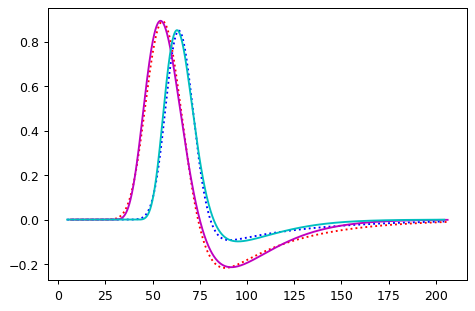

In [721]:
fig = plt.figure('temporal', dpi=90)
ax = fig.add_subplot(111)
ax.plot(t+Dc,Kt_c,':r')
ax.plot(t+Ds,Kt_s,':b')
#    temporalSimple(Ar, Ad, tauR, tauD, nR, nD, t)
k = 1.55
Kt = temporalSimple(25.9, 16.5, 5.2/k, 17/k,  10,  6,  t-12-Dc)
ax.plot(t+Dc,Kt,'m')
#k = 2.25
#Kt = temporalSimple(17.5, 6.3, 5.0/k, 23.0/k,  13,  6,  t-27-Ds)
#ax.plot(t+Ds,Kt,'c')
Kt = temporalSimple(17.6, 6.4, 2.23, 10,  13,  6,  t-27-Ds)
ax.plot(t+Ds,Kt,'c')